# Introdução

Nesse notebook analisamos resultados de testes de carga na aplicação Nutbox, para testar o desempenho do serviço utilizamos de forma crescente diferentes tamanhos de arquivos. Nosso objetivo é comparar o desempenho das versões v1.0.0 e v1.1.0 do Nutbox para uma faixa de tamanho de arquivo típica (até algumas centenas de MB). Não é de nosso interesse observar o impacto da concorrência de usuários,  portanto as requisições serão feitas por apenas um usuário e de forma sequencial.

Utilizamos as seguintes rotas:
- /upload

- /download/:id

Queremos responder as seguintes perguntas com essa análise:
- Qual a diferença de desempenho da versão v1.0.0 e da versão v1.1.0 em relação ao tempo de resposta?

- Qual a diferença de desempenho da versão v1.0.0 e da versão v1.1.0 em relação à utilização de recursos?

- Qual a diferença de desempenho da versão v1.0.0 e  da versão v1.1.0 em relação ao percentual de requisições falhas?

A análise das métricas foi realizada para duas versões distintas do servidor: "LocalStorage" e "S3". Cada uma dessas versões foi testada para diferentes tamanhos de arquivo (4MB, 8MB, 16MB, 32MB, 64MB, 128MB e 256MB).


# Hipóteses

Levantamos as seguintes hipóteses:
- Hipótese nula: não há diferença de desempenho entre as duas versões.

- H1:  A versão v1.0.0 (Storage Local) tem melhor desempenho do que a versão v1.1.0 (S3) para todas as métricas avaliadas.

# Imports e instalação de bibliotecas

Utilizaremos Pandas para manipular os arquivos CSV e Matplotlib + Seaborn para plotar os gráficos.

In [ ]:
%pip install matplotlib
%pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leitura de arquivos CSV

Vamos ler os arquivos e e armazenar os DataFrames em um dicionário para facilitar a manipulação.

In [11]:
# Defining constants
OPERATIONS = ["Download", "Upload"]
VERSIONS = ["LocalStorage", "S3"]
TAGS = ["LS", "S3"]
FILE_SIZES = [4,8,16,32,64,128,256]
CLIENT_CSV_PATH = "../logs/results/client/"
SERVER_CSV_PATH = "../logs/results/server/"

In [12]:
def create_df_dict(csv_path=None):
    """Creates a dictionary to organize dataframes used in our test.
    The showcase_structure parameter is False by the default, but when set to true it returns a showcase of our dictionary structure."""
    df_dict = {}

    for v in VERSIONS:
        df_dict[v] = {}
        for op in OPERATIONS:
            df_dict[v][op] = {}

    for t, v in list(zip(TAGS, VERSIONS)):
        for size in FILE_SIZES:
                if csv_path:
                   # Reads and inserts DataFrame into dictionary
                    df_up_and_down = pd.read_csv(f"{csv_path}{t}_{size}MB.csv", sep=',',
                                                 parse_dates=['timeStamp'],
                                                 date_format="yyyy/MM/dd hh:mm:ss")
                    for op in OPERATIONS:
                        op_dict = df_up_and_down[df_up_and_down["operation"] == op]
                        df_dict[v][op][f"{size}MB"] = op_dict
                else:
                     # Fills up dictionary with placeholders for showcase structure.
                    for op in OPERATIONS:
                        df_dict[v][op][f"{size}MB"] = f"DataFrame for {size}MB files"  

    return df_dict

# Setting up dict for dataframes
df_client_dict = create_df_dict(CLIENT_CSV_PATH)
df_server_dict = create_df_dict(SERVER_CSV_PATH)
# Showcasing dictionary structure
print("Showcase of our dictionary structure")
create_df_dict()

Showcase of our dictionary structure


{'LocalStorage': {'Download': {'4MB': 'DataFrame for 4MB files',
   '8MB': 'DataFrame for 8MB files',
   '16MB': 'DataFrame for 16MB files',
   '32MB': 'DataFrame for 32MB files',
   '64MB': 'DataFrame for 64MB files',
   '128MB': 'DataFrame for 128MB files',
   '256MB': 'DataFrame for 256MB files'},
  'Upload': {'4MB': 'DataFrame for 4MB files',
   '8MB': 'DataFrame for 8MB files',
   '16MB': 'DataFrame for 16MB files',
   '32MB': 'DataFrame for 32MB files',
   '64MB': 'DataFrame for 64MB files',
   '128MB': 'DataFrame for 128MB files',
   '256MB': 'DataFrame for 256MB files'}},
 'S3': {'Download': {'4MB': 'DataFrame for 4MB files',
   '8MB': 'DataFrame for 8MB files',
   '16MB': 'DataFrame for 16MB files',
   '32MB': 'DataFrame for 32MB files',
   '64MB': 'DataFrame for 64MB files',
   '128MB': 'DataFrame for 128MB files',
   '256MB': 'DataFrame for 256MB files'},
  'Upload': {'4MB': 'DataFrame for 4MB files',
   '8MB': 'DataFrame for 8MB files',
   '16MB': 'DataFrame for 16MB files'

In [13]:
df_client_dict["S3"]["Download"]["128MB"]['timeStamp'] = df_client_dict["S3"]["Download"]["128MB"]['timeStamp'].astype('datetime64[ns]')
df_client_dict["S3"]["Download"]["128MB"]['timeStamp'].info()

<class 'pandas.core.series.Series'>
Index: 50 entries, 50 to 99
Series name: timeStamp
Non-Null Count  Dtype         
--------------  -----         
50 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 800.0 bytes


Acima podemos ver um exemplo da estrutura do nosso dicionário

# Funções auxiliares

In [14]:
def calc_err_pctg(current_df):
    "Given a result dataframe, returns the percentage of failed requests"
    
    error_count = current_df[current_df["success"] == False]
    return (len(error_count) / len(current_df)) * 100

In [15]:
def get_metrics(op_dict):
    """Given a version dictionary with the following keys: `Download` and `Upload`, returns the mean latency and the percentage of failed requests.

    `Download` and `Upload` keys muts be dictionaries with n amount of keys and each key must be a DataFrame with the following columns: `Latency`, `success` and `version`."""
    metrics_op_df = pd.DataFrame({"Mean Latency (ms)": {},
                                  "Mean Elapsed (ms)": {},
                                  "Error percentage": {}},
                                  index=op_dict.keys())

    for k in op_dict:
        current_df = op_dict[k]
        metrics_op_df.loc[k]["Mean Latency (ms)"] = round(current_df["Latency"].mean(), 2)
        metrics_op_df.loc[k]["Mean Elapsed (ms)"] = round(current_df["elapsed"].mean(), 2)
        metrics_op_df.loc[k]["Error percentage"] = round(calc_err_pctg(current_df))

    key = list(op_dict.keys())[0]
    idx = list(op_dict[key].index)[0]
    metrics_op_df['Version'] = op_dict[key].loc[idx]['version']

    return metrics_op_df

In [16]:
def get_metrics_server(op_dict, metric, label, date_type):
    """Given a version dictionary with the following keys: `Download` and `Upload`, returns the average CPU usage.

    `Download` and `Upload` keys muts be dictionaries with n amount of keys and each key must be a DataFrame with the following columns: `Latency`, `success` and `version`."""
    metrics_op_df = pd.DataFrame({f"Average {label} usage ({date_type})": {},
                                  f"Max - {label} usage ({date_type})" : {},
                                  f"Min - {label} usage ({date_type})" : {}
                                  },
                                  
                                  index=op_dict.keys())

    for k in op_dict:
        current_df = op_dict[k]
        metrics_op_df.loc[k][f"Average {label} usage ({date_type})"] = round(current_df[f'{metric}'].mean(), 2)
        metrics_op_df.loc[k][f"Max - {label} usage ({date_type})"] = round(current_df[f'{metric}'].max(), 2)
        metrics_op_df.loc[k][f"Min - {label} usage ({date_type})"] = round(current_df[f'{metric}'].min(), 2)

    key = list(op_dict.keys())[0]
    idx = list(op_dict[key].index)[0]
    metrics_op_df['Version'] = op_dict[key].loc[idx]['version']

    return metrics_op_df

In [17]:
def create_dict(data_dict, metrics_list):

    columns = ['timeStamp', 'operation', 'version', 'size']
    columns.extend(metrics_list)

    data_frames_dict = {}

    for v in VERSIONS:
        for op in OPERATIONS:
            for size in FILE_SIZES:
                df = data_dict[v][op][f"{size}MB"][columns]
                identifier = f'{v}_{op}_{size}MB'
                data_frames_dict[identifier] = df

    return data_frames_dict


In [18]:
def plot_metric(v1_metrics, v2_metrics, col, ax=None):
    """Barplots metric of the two versions side by side."""

    if not ax:
        fig = plt.figure(figsize=[15,5])
        ax = plt.axes()
        fig.add_axes(ax)

    df_up_metrics = pd.concat([v1_metrics, v2_metrics])
    ax.set_ylabel(col)
    bars = sns.barplot(data=df_up_metrics, x=df_up_metrics.index, y=col, hue="Version", ax=ax)
    
    for i in bars.containers:
        bars.bar_label(i)

In [19]:
def plot_behaviour_comparison(df_dict, operation, size, column, ylabel=None, xlabel=None, ax=None, include_legend=False, include_label=False):
    """Plots in a line graph the latency's behaviour in the y axis and the request index in the x axis"""
    if not ax:
        ax = plt

    for v in df_dict:
        current_df = df_dict[v][operation][size]
        first_index = list(current_df.index)[0]
        ax.plot(current_df.loc[first_index + 5:][column], label=v)

    if include_label:
        plt.ylabel(ylabel if ylabel else column)
        plt.xlabel(xlabel if xlabel else "")
    if include_legend: plt.legend(loc="upper right")

In [20]:
def plot_all_size_behaviour_comparison(df_dict, operation, column, supxlabel=None, supylabel=None, enable_yticks=False, init_yticks=None, limit_yticks=None, step_yticks=None):
    fig, axs = plt.subplots(3,3, figsize=(20,10))
    fig.delaxes(axs[2][1])
    fig.delaxes(axs[2][2])

    fig.supylabel(supylabel if supylabel else "")
    fig.supxlabel(supxlabel if supxlabel else "")
    file_idx = 0

    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            # Handling index out of bounds caused by deleted axes
            if i == 2 and j > 0: break

            current_ax = axs[i][j]
            title = f"{FILE_SIZES[file_idx]}MB"

            plot_behaviour_comparison(df_dict, operation, title, column, ax=current_ax)
            current_ax.set_title(title)
            if enable_yticks: current_ax.set_yticks(list(range(init_yticks, limit_yticks, step_yticks)))
            # Setting figure x and y label
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center')
            
            file_idx += 1

# Análises

## Client

Métricas utilizadas na análise:
- Elapsed (tempo decorrido)
    - Tempo desde o início do envio da requisição até a recepção do **último** bit da resposta.
- Failed request percentage
    - Porcentagem de requisições falhas

### Métricas de upload

Criando DataFrame com métricas relevantes

In [21]:
# Creating DataFrames for upload metrics on each version
ls_metrics_up_df = get_metrics(df_client_dict[VERSIONS[0]]["Upload"])
s3_metrics_up_df = get_metrics(df_client_dict[VERSIONS[1]]["Upload"])

#### Percentual de requisições falhas

Através dos dois DataFrames abaixo podemos observar que **não houveram erros para nenhum dos tamanhos de arquivo testados**. Pois nosso percentual de erro em ambas as versões para todos os tamanhos de arquivo é **0%**.

In [22]:
ls_metrics_up_df["Error percentage"].to_frame()

,Error percentage
4MB,0.0
8MB,0.0
16MB,0.0
32MB,0.0
64MB,0.0
128MB,0.0
256MB,0.0


In [23]:
s3_metrics_up_df["Error percentage"].to_frame()

,Error percentage
4MB,0.0
8MB,0.0
16MB,0.0
32MB,0.0
64MB,0.0
128MB,0.0
256MB,0.0


#### Tempo decorrido

De acordo com os gráficos abaixo, podemos afirmar o seguinte sobre a métrica de tempo decorrido na operação de upload:

1. A versão Local Storage teve **valores médios menores** para todos os tamanhos
    - Uma **possível justificativa** para isso é a latência da comunicação da aplicação com o S3 para acessar o arquivo enquanto o Local Storage acessa o arquivo localmente na máquina

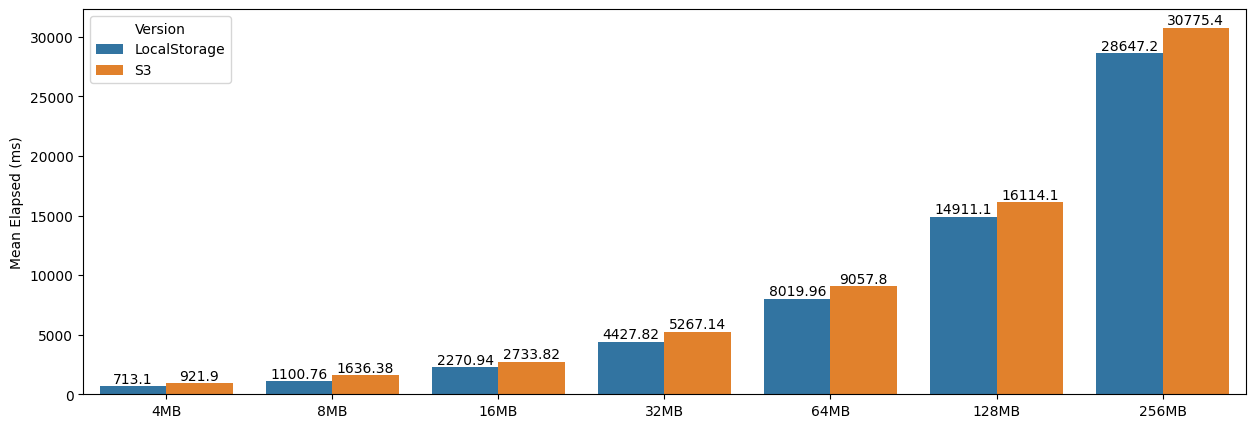

In [24]:
plot_metric(ls_metrics_up_df, s3_metrics_up_df, "Mean Elapsed (ms)")

2. As curvas de tempo decorrido das duas versões se assemelham muito entre si, porém a curva da versão **S3 tem um crescimento mais acentuado**

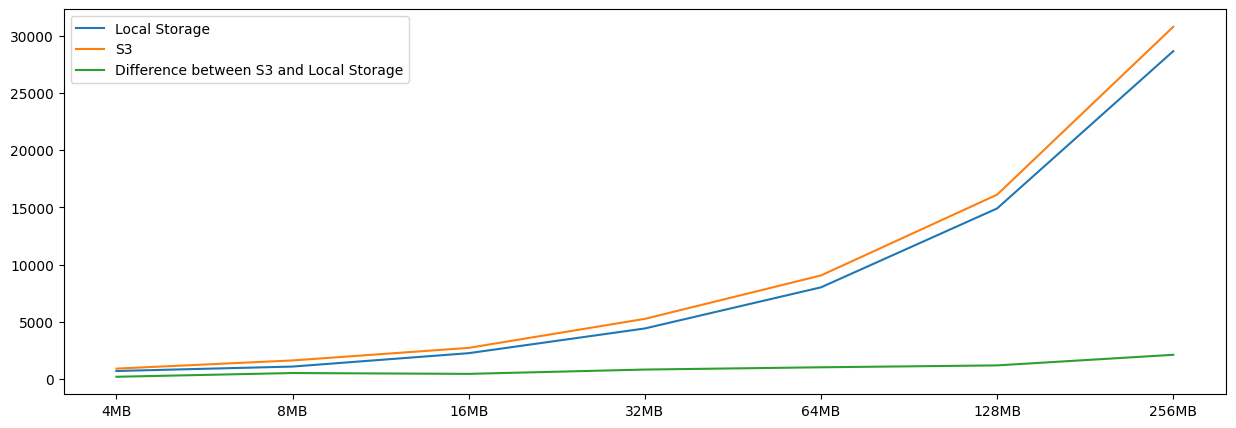

In [25]:
plt.figure(figsize=(15,5))
plt.plot(ls_metrics_up_df["Mean Elapsed (ms)"], label="Local Storage")
plt.plot(s3_metrics_up_df["Mean Elapsed (ms)"], label="S3")
plt.plot(s3_metrics_up_df["Mean Elapsed (ms)"] - ls_metrics_up_df["Mean Elapsed (ms)"], label="Difference between S3 and Local Storage")
plt.legend(loc="upper left")

Nos gráficos abaixo podemos ver o **comportamento do tempo decorrido** durante o teste para os diferentes tamanhos de arquivos na operação de upload.

**OBS: `Request Number` representa o número da requisição de acordo com a ordem em que elas foram executadas, portanto  requisição de número 1 é a primeira, a de número 2 é a segunda e assim por diante.**  
**OBS2: Prestar atenção a escala dos gráficos**

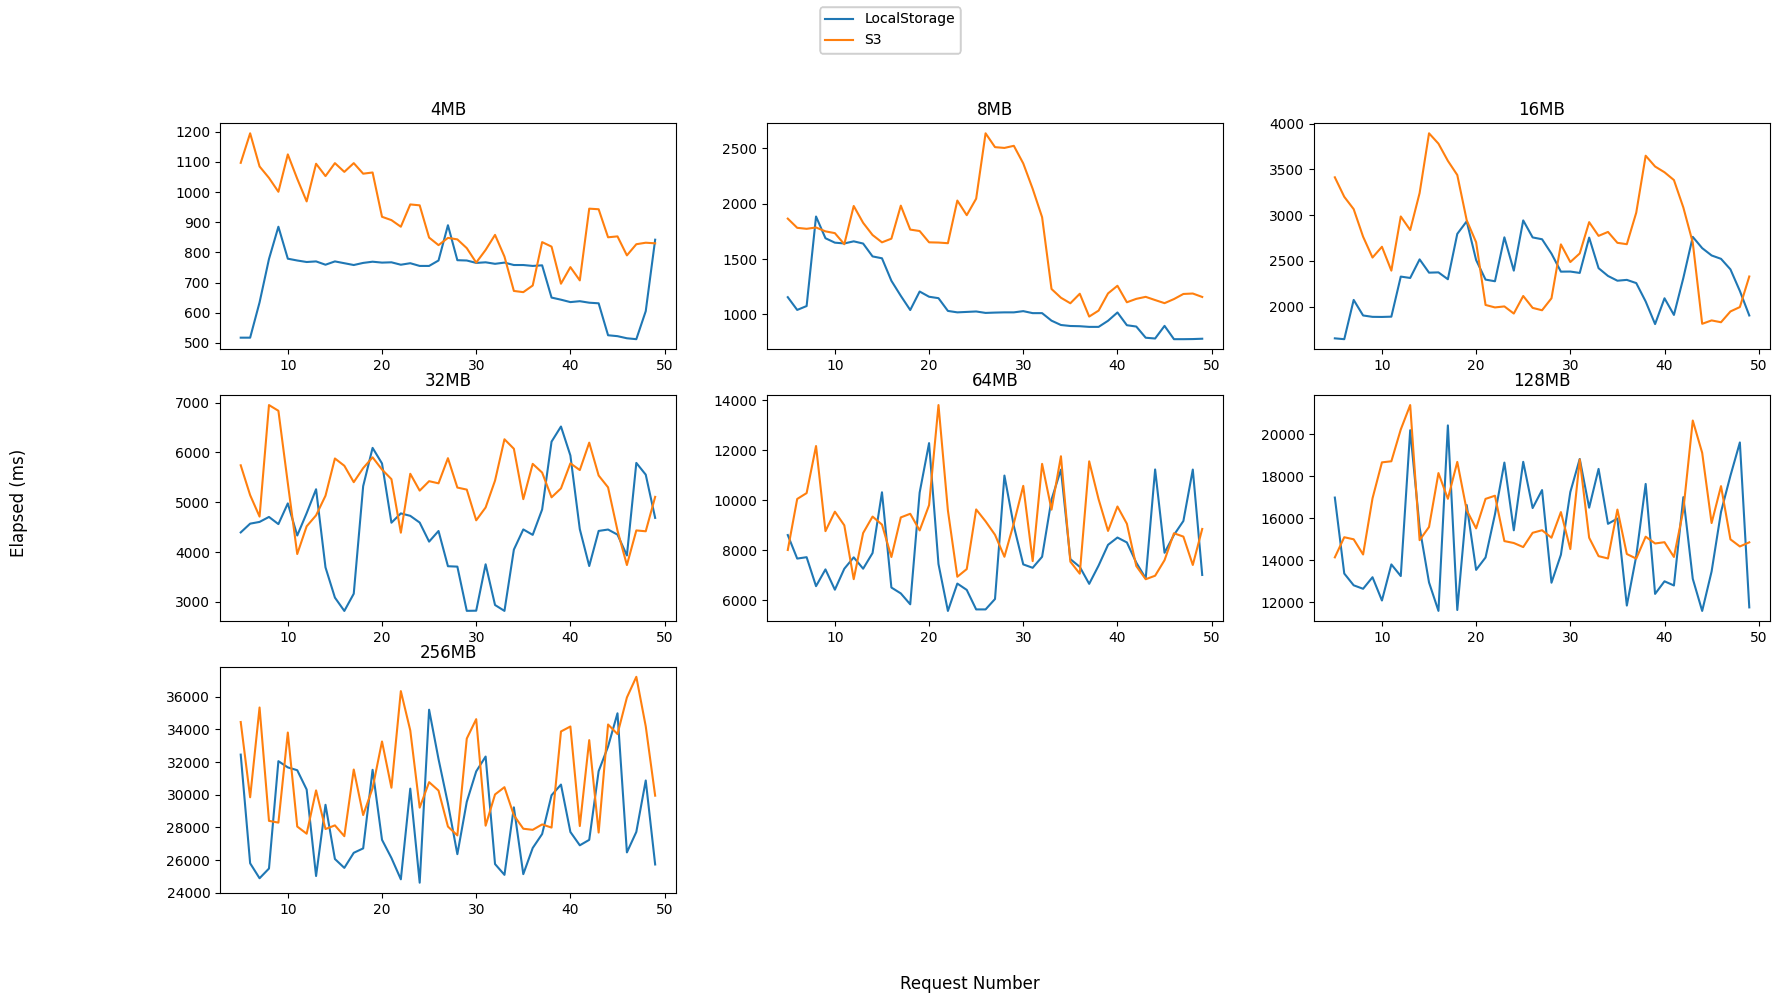

In [26]:
plot_all_size_behaviour_comparison(df_client_dict, "Upload", "elapsed", supxlabel="Request Number", supylabel="Elapsed (ms)")

Do gráfico acima podemos observar o seguinte:
- A curva da versão Local Storage é inferior à curva do S3 com exceção de alguns picos.

- Com o aumento do tamanho do arquivo utilizado no teste também temos o aumento da quantidade de picos e consequentemente da amplitude das curvas.
    - Um motivo para esse aumento na quantidade de picos pode ser devido a influência do Garbage Colector.

### Métricas de download

Criando DataFrame com métricas relevantes

In [27]:
# Creating DataFrames for download metrics on each version
ls_metrics_down_df = get_metrics(df_client_dict[VERSIONS[0]]["Download"])
s3_metrics_down_df = get_metrics(df_client_dict[VERSIONS[1]]["Download"])

#### Percentual de requisições falhas

Através dos dois DataFrames abaixo podemos observar que **não houveram erros para nenhum dos tamanhos de arquivo testados**. Pois nosso percentual de erro em ambas as versões para todos os tamanhos de arquivo é 0%.

In [28]:
ls_metrics_down_df["Error percentage"].to_frame()

,Error percentage
4MB,0.0
8MB,0.0
16MB,0.0
32MB,0.0
64MB,0.0
128MB,0.0
256MB,0.0


In [29]:
ls_metrics_down_df["Error percentage"].to_frame()

,Error percentage
4MB,0.0
8MB,0.0
16MB,0.0
32MB,0.0
64MB,0.0
128MB,0.0
256MB,0.0


#### Tempo decorrido

Ao analisar os gráficos abaixos podemos perceber que as os mesmos pontos levantados para a métrica de upload são válidos para a de download:

1. A versão Local Storage teve **valores médios menores** para todos os tamanhos

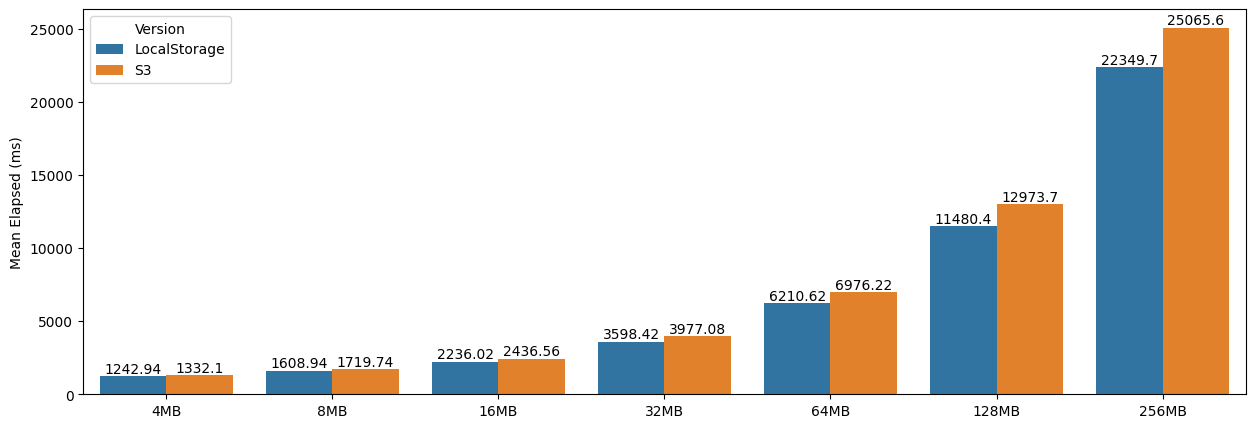

In [30]:
plot_metric(ls_metrics_down_df, s3_metrics_down_df, "Mean Elapsed (ms)")

2. As curvas de tempo decorrido das duas versões se assemelham muito entre si, porém a curva da versão **S3 tem um crescimento mais acentuado**

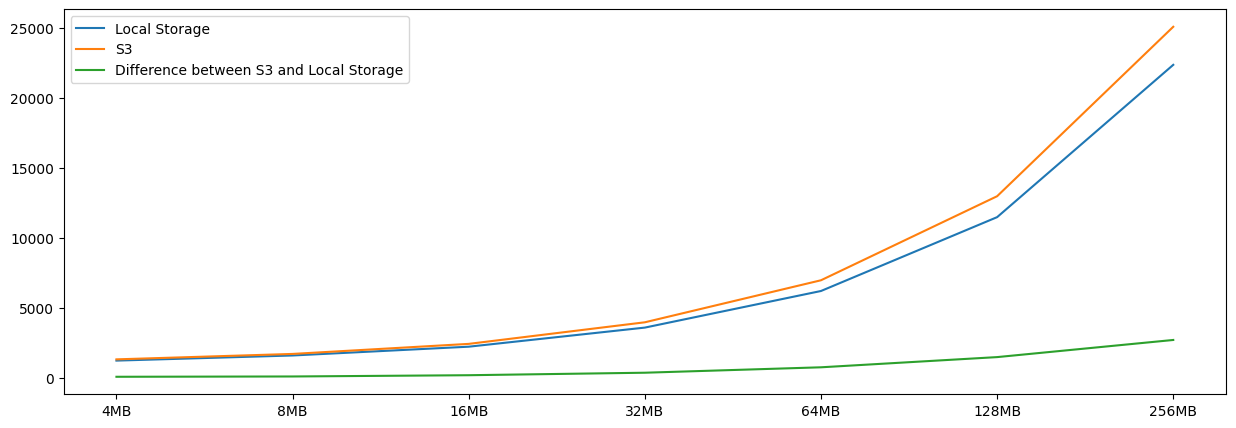

In [31]:
plt.figure(figsize=(15,5))
plt.plot(ls_metrics_down_df["Mean Elapsed (ms)"], label="Local Storage")
plt.plot(s3_metrics_down_df["Mean Elapsed (ms)"], label="S3")
plt.plot(s3_metrics_down_df["Mean Elapsed (ms)"] - ls_metrics_down_df["Mean Elapsed (ms)"], label="Difference between S3 and Local Storage")
plt.legend(loc="upper left")

Nos gráficos abaixo podemos ver o **comportamento do tempo decorrido** durante o teste para os diferentes tamanhos de arquivos na operação de download.

**OBS: `Request Number` representa o número da requisição de acordo com a ordem em que elas foram executadas, portanto  requisição de número 1 é a primeira, a de número 2 é a segunda e assim por diante**  
**OBS2: Prestar atenção a escala dos gráficos**

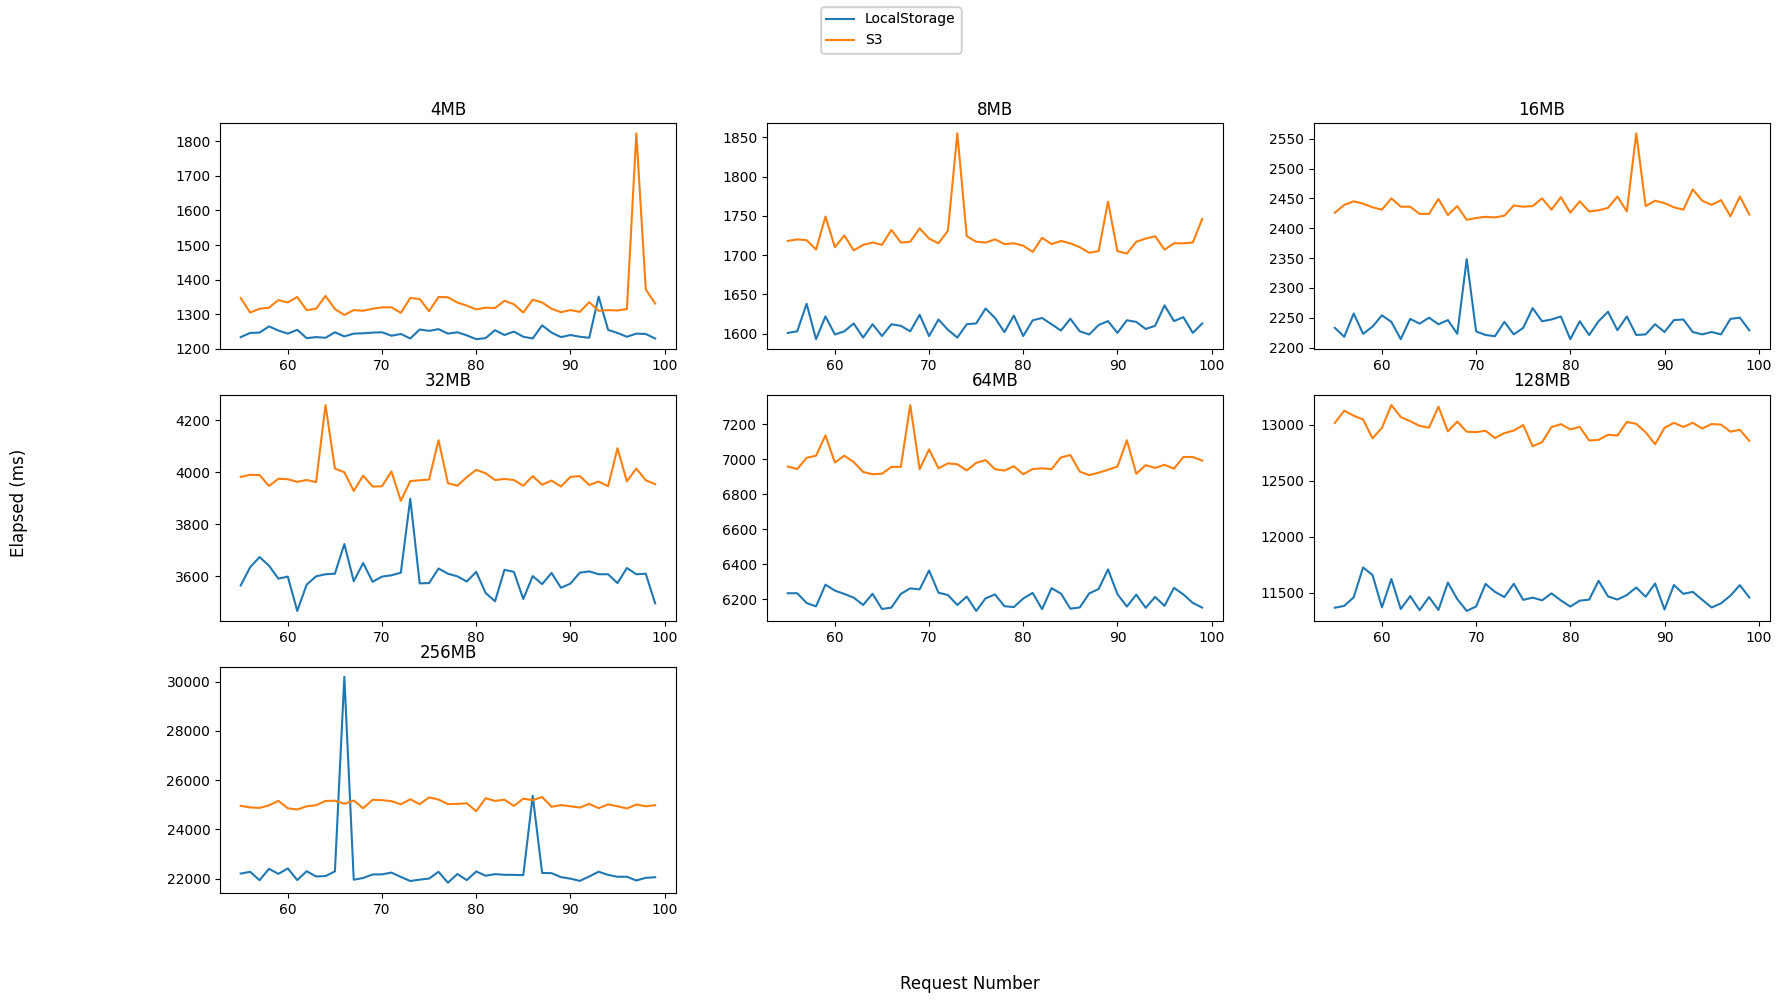

In [32]:
plot_all_size_behaviour_comparison(df_client_dict, "Download", "elapsed", supxlabel="Request Number", supylabel="Elapsed (ms)")

Do gráfico acima podemos observar o seguinte:
- A curva da versão Local Storage é inferior à curva do S3 com exceção de alguns raros picos.
- Diferente da curva de upload a quantidade de picos é muito menor

## Server

Métricas utilizadas na análise:

- Utilização de CPU
    - Tempo gasto em segundos por todos os núcleos de CPU juntos
    - Tempo gasto em cada modo:
        - Softirq - Manutenção de softirqs
        - Steal - Tempo gasto em outros sistemas operacionais ao executar em um ambiente virtualizado    
        - System - Processos em execução no modo kernel
        - User - Processos normais em execução no modo de usuário
        
- Utilização de Memória
    - Percentual da utilização de memória durante o teste.
    
Os dados apresentados nos logs do servidor foram obtidos por meio do banco de dados do Prometheus, utilizando scrapes regulares a cada 0.2 segundos. Isso significa que, a cada 0.2 segundos, o Prometheus realizou uma coleta de informações sobre o servidor em questão, registrando métricas como a média de uso de CPU e a porcentagem média de uso de memória.


### Utilização de CPU

#### Uso da CPU durante o processamento de operações de Upload

##### Tabela com a média e os valores máximos e mínimos para cada tamanho de arquivo em ambas as versões

In [33]:
ls_cpu_up_df = get_metrics_server(df_server_dict[VERSIONS[0]]["Upload"], "cpu_total_usage", "CPU", "%")
s3_cpu_up_df = get_metrics_server(df_server_dict[VERSIONS[1]]["Upload"], "cpu_total_usage", "CPU", "%")

In [34]:
ls_cpu_up_df

,Average CPU usage (%),Max - CPU usage (%),Min - CPU usage (%),Version
4MB,5.56,8.38,1.31,LocalStorage
8MB,5.80,8.09,1.31,LocalStorage
16MB,12.21,28.41,1.01,LocalStorage
32MB,11.72,25.33,4.06,LocalStorage
64MB,8.26,25.91,0.81,LocalStorage
128MB,12.75,57.78,0.20,LocalStorage
256MB,7.67,58.22,0.71,LocalStorage


In [35]:
s3_cpu_up_df

,Average CPU usage (%),Max - CPU usage (%),Min - CPU usage (%),Version
4MB,0.19,0.40,0.1,S3
8MB,0.21,0.60,0.0,S3
16MB,0.19,0.50,0.0,S3
32MB,0.21,0.50,0.0,S3
64MB,0.21,0.60,0.0,S3
128MB,4.15,21.71,0.0,S3
256MB,6.23,37.06,0.1,S3


##### Análise e plots

Através da análise dos logs referente ao uso de CPU para ambas as versões, podemos concluir que a versão "LocalStorage"(LS) apresentou uma média mais alta no uso da CPU durante a realização dos uploads em todos os tamanhos de arquivo em comparação com a versão "S3". Isso indica que a versão "LocalStorage" demanda mais recursos da CPU para executar as operações em comparação com a versão "S3".

Essa diferença entre as versões “LS” e "S3" pode ser influenciada por fatores como a arquitetura de armazenamento utilizada por cada uma delas. A versão "LocalStorage" utiliza armazenamento local, os dados são armazenados diretamente nos discos do servidor. Por outro lado, a versão "S3" utiliza o serviço de armazenamento da AWS (Amazon S3), que é um serviço de armazenamento altamente escalável e distribuído.

A arquitetura de armazenamento pode influenciar e resultar em padrões de acesso e Elapsed(latência) diferentes para recuperar os dados. Como observamos anteriormente nas análises do Cliente, a versão "LocalStorage" teve um elapsed menor possivelmente pelo fato do local de armazenamento, pois os dados são acessados diretamente dos discos locais, enquanto a versão "S3" teve um elapsed ligeiramente maior provavelmente devido à natureza distribuída do serviço, onde os dados podem ser replicados em várias regiões geográficas.


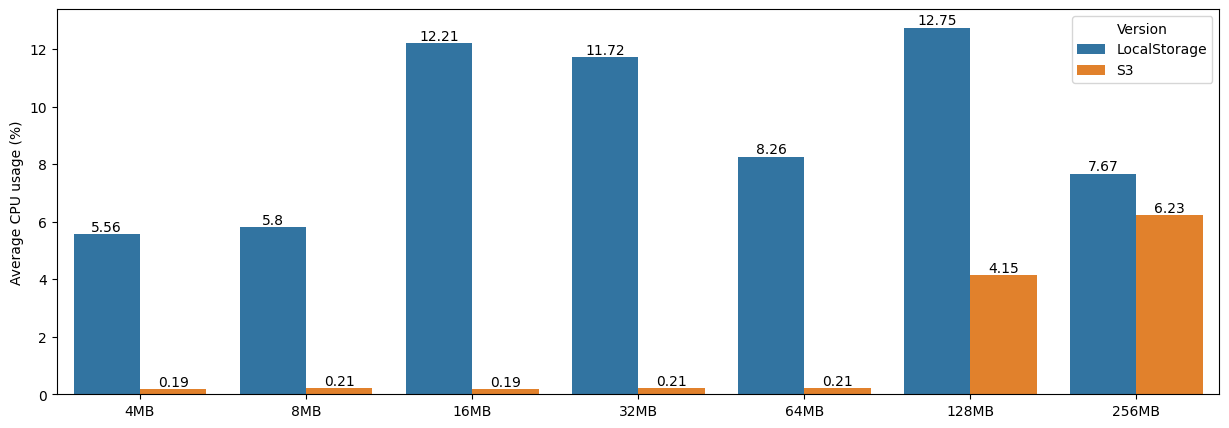

In [36]:
plot_metric(ls_cpu_up_df, s3_cpu_up_df, "Average CPU usage (%)")

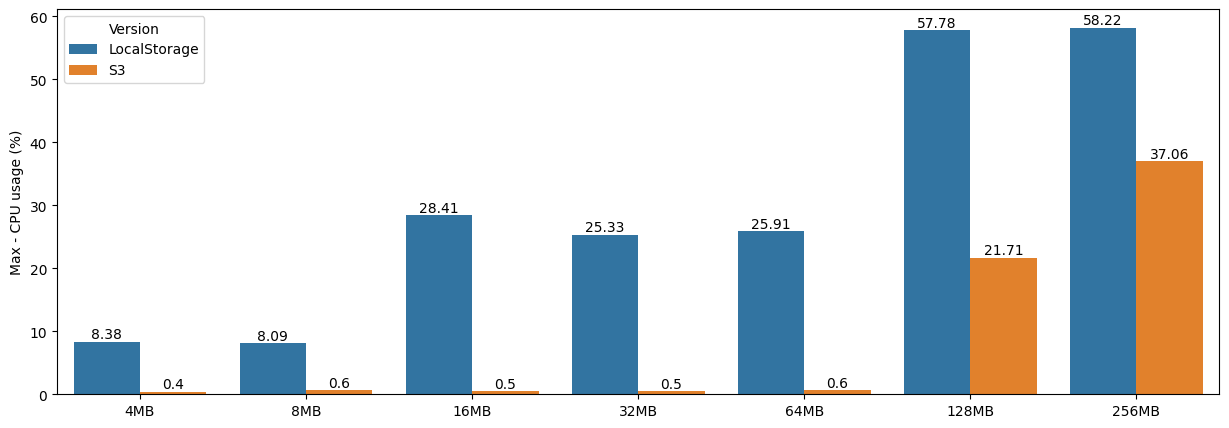

In [37]:
plot_metric(ls_cpu_up_df, s3_cpu_up_df, "Max - CPU usage (%)")

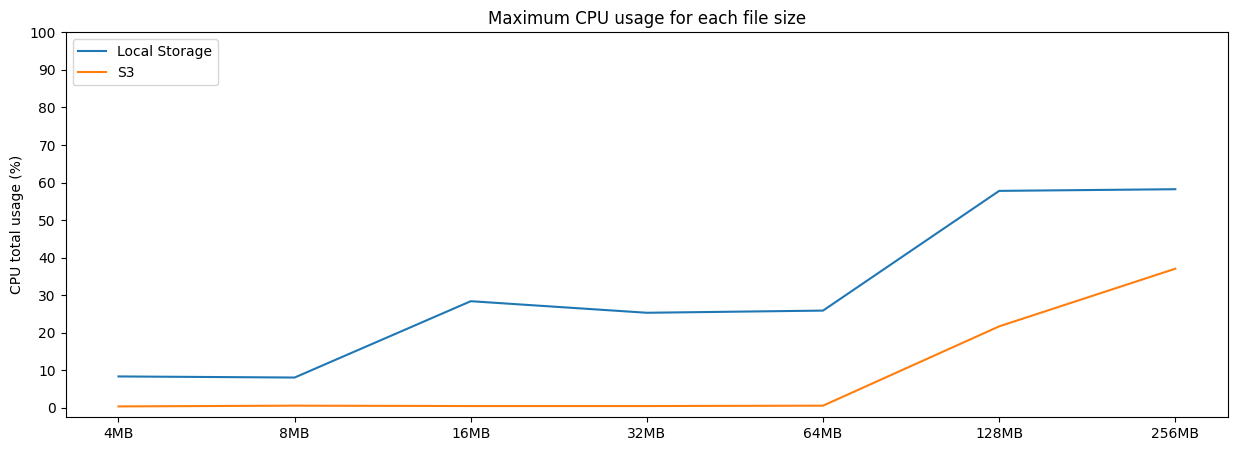

In [38]:
plt.figure(figsize=(15,5))
plt.ylabel("CPU total usage (%)")
plt.title("Maximum CPU usage for each file size")
plt.plot(ls_cpu_up_df["Max - CPU usage (%)"], label="Local Storage")
plt.plot(s3_cpu_up_df["Max - CPU usage (%)"], label="S3")
plt.yticks(list(range(0, 101, 10)))
# plt.plot(ls_cpu_up_df["Max - CPU usage (%)"] - s3_cpu_up_df["Max - CPU usage (%)"], label="Difference between Local Storage and S3")
plt.legend(loc="upper left")

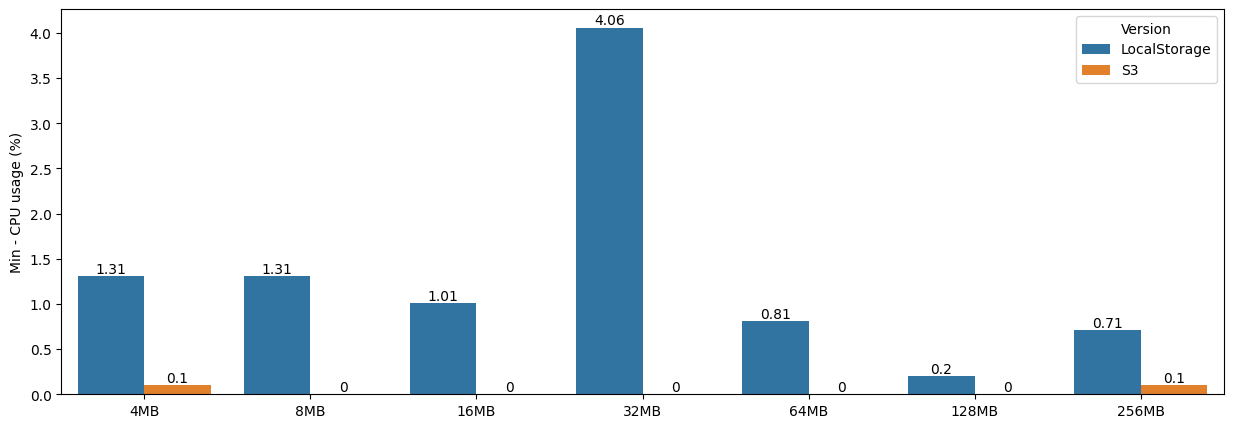

In [39]:
plot_metric(ls_cpu_up_df, s3_cpu_up_df, "Min - CPU usage (%)")

Utilização de CPU durante o processo de upload ao decorrer do teste para cada tamanho de arquivo

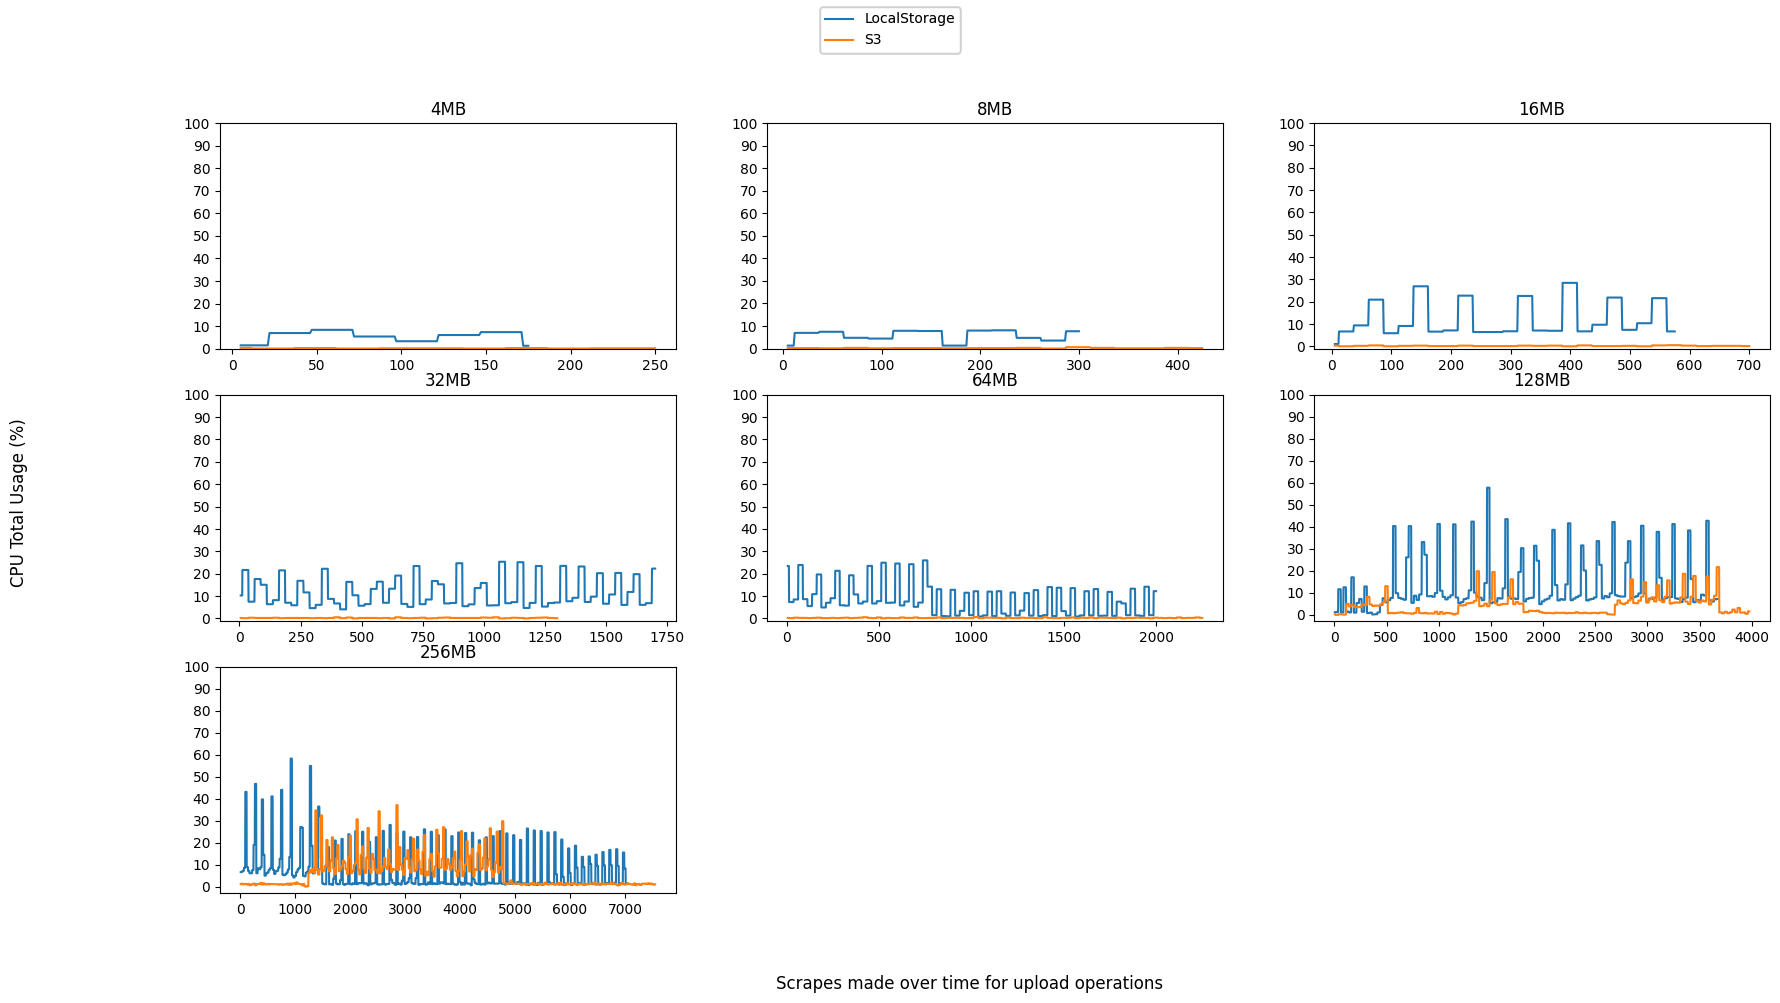

In [40]:
plot_all_size_behaviour_comparison(df_server_dict, "Upload", "cpu_total_usage", supxlabel="Scrapes made over time for upload operations", supylabel="CPU Total Usage (%)", enable_yticks=True, init_yticks=0, limit_yticks=101, step_yticks=10)

Essas diferenças de armazenamento podem impactar também o uso da CPU, pois o tempo de acesso aos dados e a complexidade do sistema de armazenamento podem afetar o desempenho geral da aplicação e, por consequência, o uso da CPU, como pode ser observado nos gráficos do comportamento da CPU.

#### Uso da CPU durante o processamento de operações de Download

##### Tabela com a média e os valores máximos e mínimos para cada tamanho de arquivo em ambas as versões

In [41]:
ls_cpu_down_df = get_metrics_server(df_server_dict[VERSIONS[0]]["Download"], "cpu_total_usage", "CPU", "%")
s3_cpu_down_df = get_metrics_server(df_server_dict[VERSIONS[1]]["Download"], "cpu_total_usage", "CPU", "%")

In [42]:
ls_cpu_down_df

,Average CPU usage (%),Max - CPU usage (%),Min - CPU usage (%),Version
4MB,5.94,14.21,1.11,LocalStorage
8MB,5.54,8.38,0.30,LocalStorage
16MB,10.89,22.19,4.06,LocalStorage
32MB,12.87,30.67,5.35,LocalStorage
64MB,5.66,13.69,0.91,LocalStorage
128MB,14.34,66.06,4.78,LocalStorage
256MB,0.80,18.86,0.00,LocalStorage


In [43]:
s3_cpu_down_df

,Average CPU usage (%),Max - CPU usage (%),Min - CPU usage (%),Version
4MB,0.21,0.60,0.1,S3
8MB,0.18,0.30,0.0,S3
16MB,0.20,0.50,0.0,S3
32MB,0.24,1.11,0.0,S3
64MB,0.89,6.64,0.0,S3
128MB,6.05,28.88,0.2,S3
256MB,14.61,42.71,0.1,S3


##### Análise e plots

A análise dos logs referentes ao uso de CPU para as operações de download nas versões "LocalStorage" (LS) e "S3" nos permitiu observar padrões interessantes à medida que o tamanho do arquivo aumenta, podemos notar que o comportamento varia significativamente entre as duas versões.

Versão "LocalStorage" (LS):

Observamos que a versão "LocalStorage" apresentou um uso de CPU mais elevado em todas as categorias de tamanho de arquivo. Conforme o tamanho do arquivo aumenta, o uso de CPU na versão "LocalStorage" também aumenta consideravelmente, sugerindo que o impacto no uso da CPU é mais acentuado à medida que os arquivos se tornam maiores. Além disso, a versão "LocalStorage" também apresenta valores mínimos de uso de CPU relativamente mais altos em comparação com a versão "S3".

Versão "S3":

Por outro lado, a versão "S3" demonstrou um uso de CPU consideravelmente menor em todas as categorias de tamanho de arquivo. À medida que o tamanho do arquivo aumenta, observamos um aumento geral no uso de CPU na versão "S3", mas esse aumento é significativamente menor em comparação com a versão "LocalStorage". Além disso, a versão "S3" apresenta valores mínimos de uso de CPU próximos de zero para a maioria dos tamanhos de arquivo, indicando que a variação no uso da CPU é menor nessa versão.

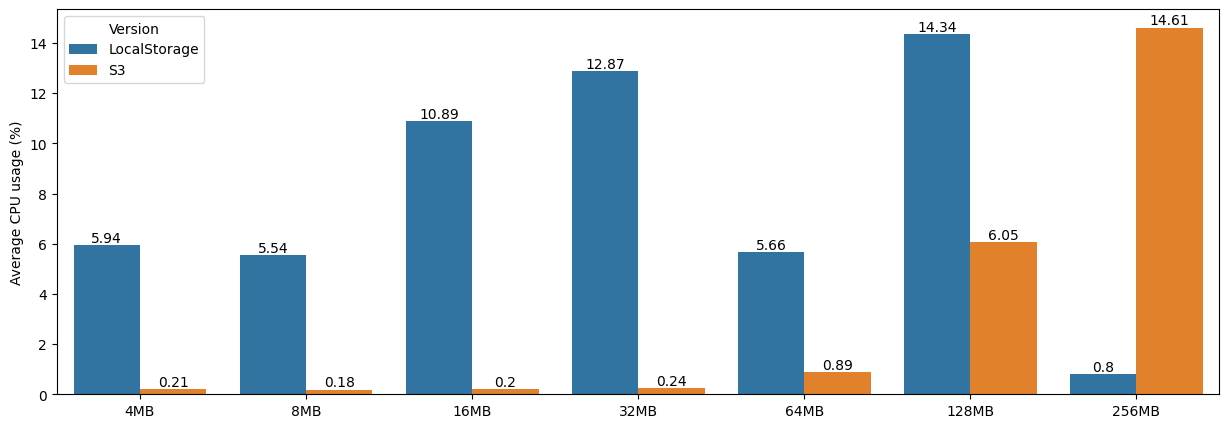

In [44]:
plot_metric(ls_cpu_down_df, s3_cpu_down_df, "Average CPU usage (%)")

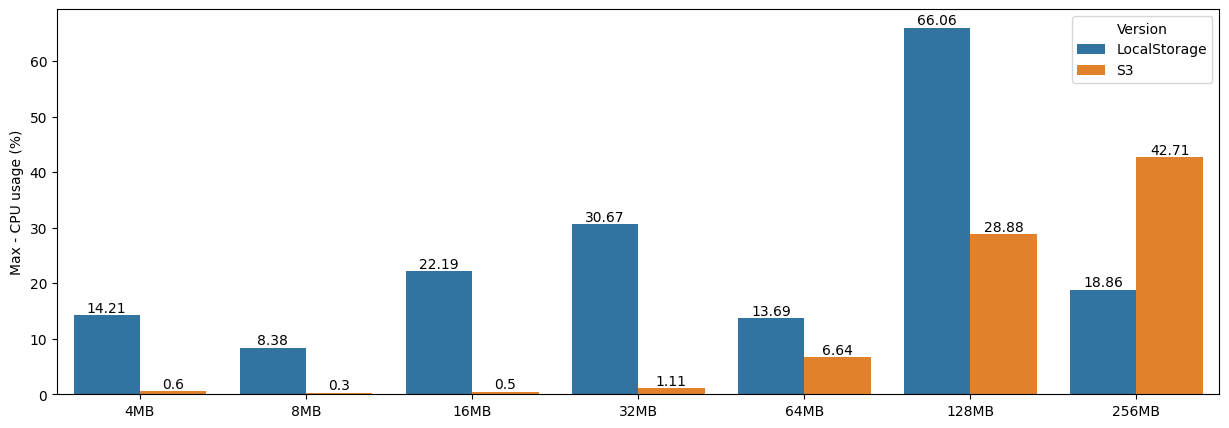

In [45]:
plot_metric(ls_cpu_down_df, s3_cpu_down_df, "Max - CPU usage (%)")

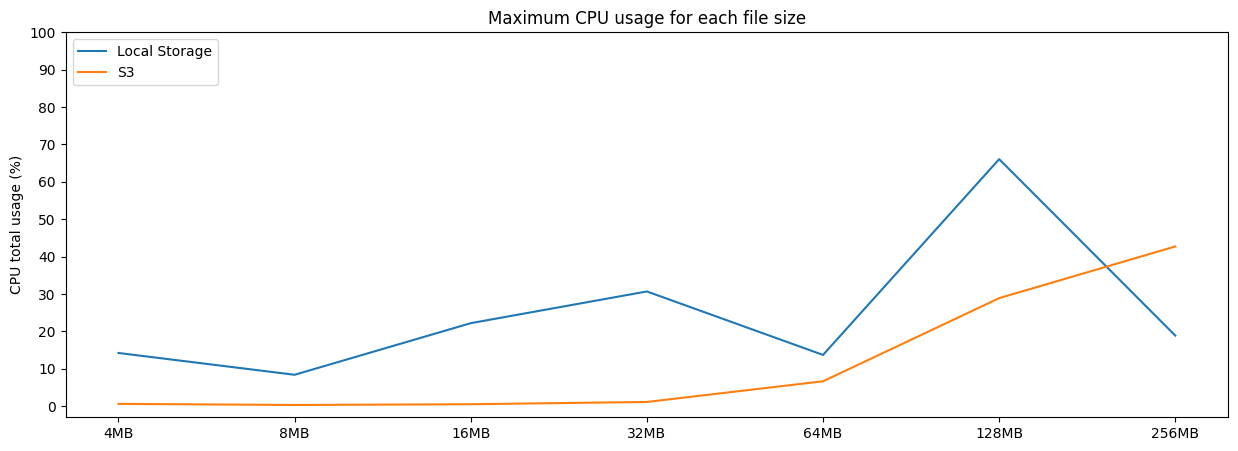

In [46]:
plt.figure(figsize=(15,5))
plt.ylabel("CPU total usage (%)")
plt.title("Maximum CPU usage for each file size")
plt.plot(ls_cpu_down_df["Max - CPU usage (%)"], label="Local Storage")
plt.plot(s3_cpu_down_df["Max - CPU usage (%)"], label="S3")
plt.yticks(list(range(0, 101, 10)))
plt.legend(loc="upper left")

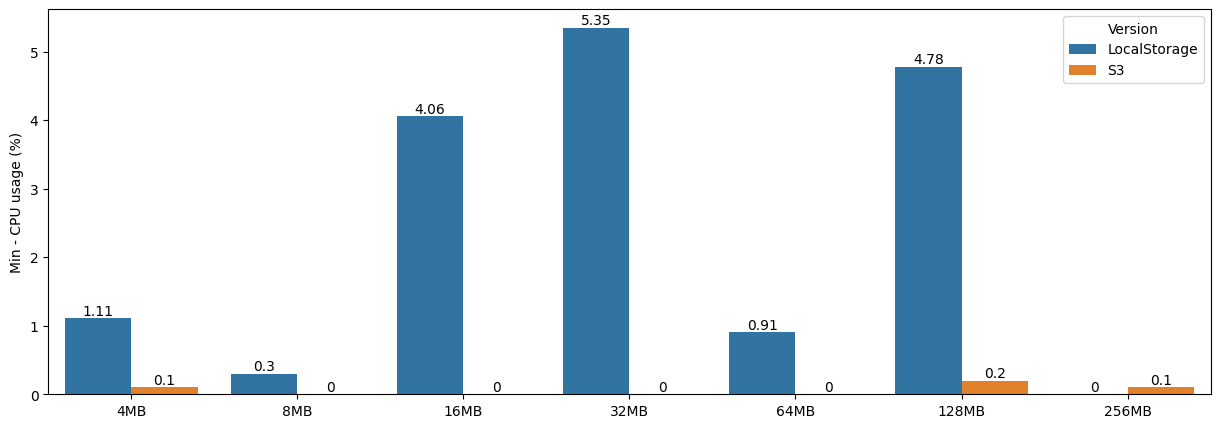

In [47]:
plot_metric(ls_cpu_down_df, s3_cpu_down_df, "Min - CPU usage (%)")

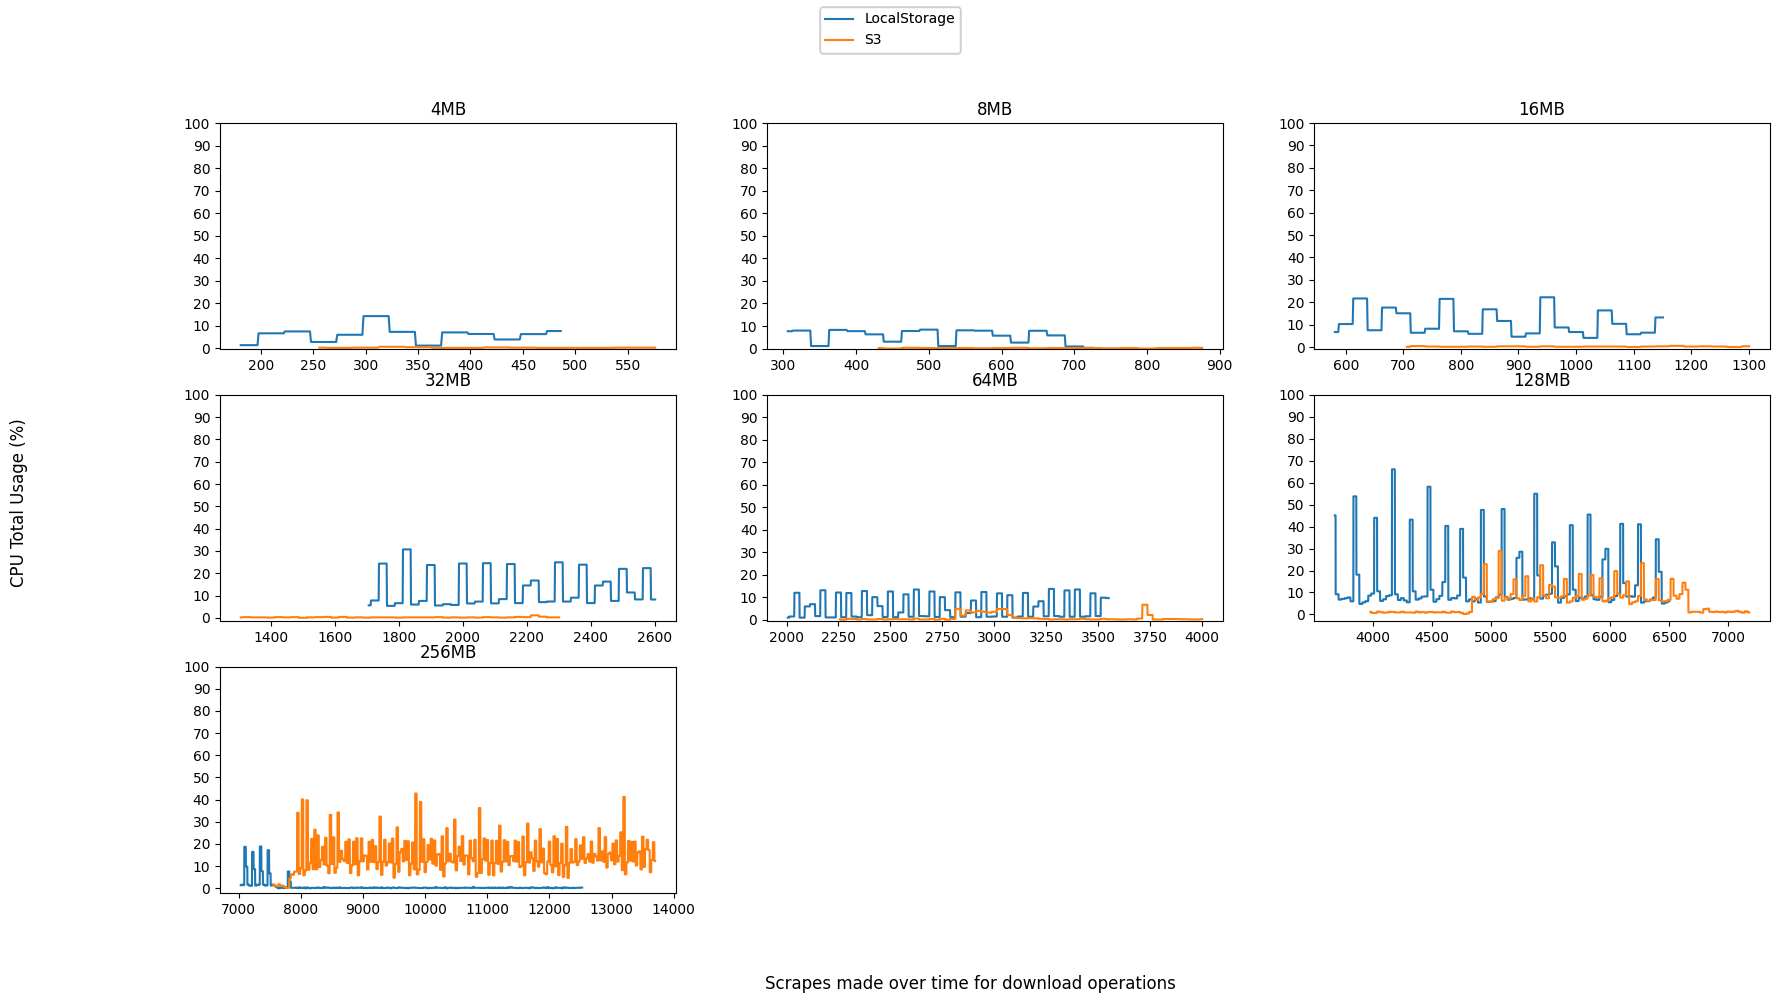

In [48]:
plot_all_size_behaviour_comparison(df_server_dict, "Download", "cpu_total_usage", supxlabel="Scrapes made over time for download operations", supylabel="CPU Total Usage (%)", enable_yticks=True, init_yticks=0, limit_yticks=101, step_yticks=10)

Com base na análise dos dados durante o intervalo da realização de downloads podemos concluir mais uma vez que a versão "LocalStorage" demanda mais recursos da CPU para executar essas operações em comparação com a versão "S3". Esse comportamento pode ser explicado pelas diferenças de arquitetura de armazenamento utilizadas por cada versão. 

No entanto, durante a execução do teste no endpoint de download o mesmo foi configurado para utilizar um arquivo apenas, com o tamanho referente a rodada de teste durante todas das 50 repetições para cada intervalo de arquivo, um dúvida que foi levantada ao decorrer das análises do servidor era a hipótese de que  a aplicação pode está armazenando o arquivo em cache ao invés de realizar outra leitura no disco, caso isso esteja acontecendo pode está gerando falsas métricas. Isso pode tá acontecendo porque o ID utilizado no download é sempre o mesmo, só varia entre a faixa do tamanho de arquivos.  



### Utilização de Memória

#### Uso da Memória durante o processamento de operações de Upload

##### Tabela com a média e os valores máximos e mínimos para cada tamanho de arquivo em ambas as versões

In [49]:
ls_memory_up_df = get_metrics_server(df_server_dict[VERSIONS[0]]["Upload"], "raw_usage", "Memory", "%")
s3_memory_up_df = get_metrics_server(df_server_dict[VERSIONS[1]]["Upload"], "raw_usage", "Memory", "%")

In [50]:
ls_memory_up_df

,Average Memory usage (%),Max - Memory usage (%),Min - Memory usage (%),Version
4MB,45.21,45.92,44.77,LocalStorage
8MB,34.26,34.59,33.67,LocalStorage
16MB,43.12,47.73,38.94,LocalStorage
32MB,43.39,47.53,38.98,LocalStorage
64MB,44.01,49.35,38.70,LocalStorage
128MB,42.41,46.95,38.88,LocalStorage
256MB,47.64,50.05,38.89,LocalStorage


In [51]:
s3_memory_up_df

,Average Memory usage (%),Max - Memory usage (%),Min - Memory usage (%),Version
4MB,48.99,48.99,48.99,S3
8MB,48.99,48.99,48.99,S3
16MB,49.04,49.05,49.03,S3
32MB,49.03,49.06,48.97,S3
64MB,49.04,49.04,49.03,S3
128MB,49.02,49.71,48.46,S3
256MB,49.30,50.51,48.91,S3


##### Análise do comportamento

A média de uso de memória (%) para ambas as versões "LocalStorage" e "S3" está próxima, variando de aproximadamente 42% a 49%, com diferenças máximas de cerca de 4%. Isso sugere que ambas as versões têm comportamentos semelhantes em relação ao consumo médio de memória para diferentes tamanhos de arquivo.

A versão "LocalStorage" parece ter uma tendência a apresentar valores médios mais baixos de uso de memória em comparação com a versão "S3". No entanto, essas diferenças são bastante sutis e não parecem ser significativas em termos de impacto geral no desempenho.

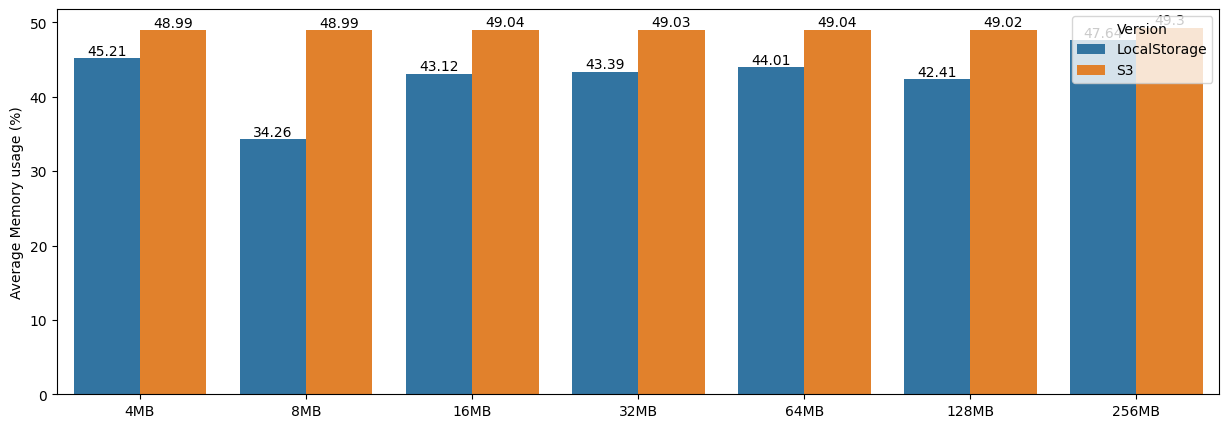

In [52]:
plot_metric(ls_memory_up_df, s3_memory_up_df, "Average Memory usage (%)")

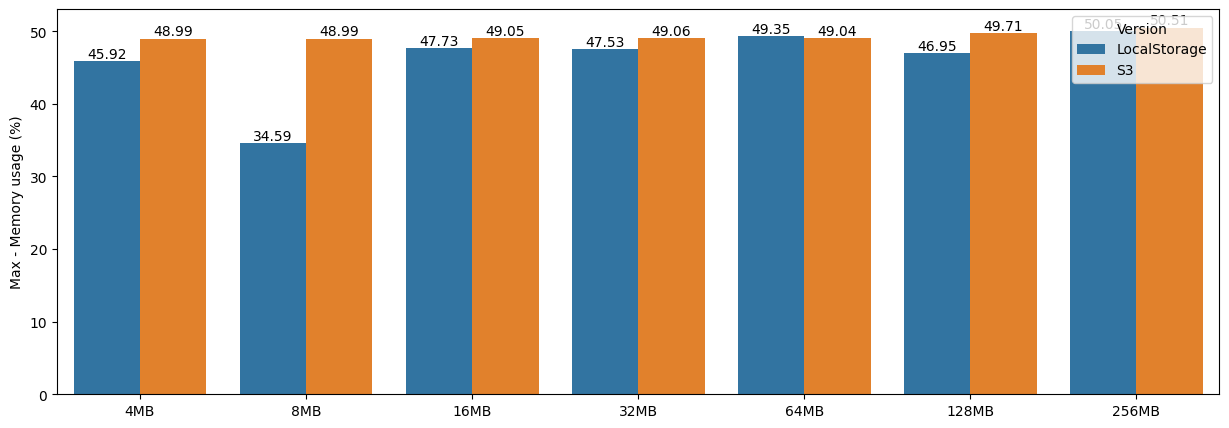

In [53]:
plot_metric(ls_memory_up_df, s3_memory_up_df, "Max - Memory usage (%)")


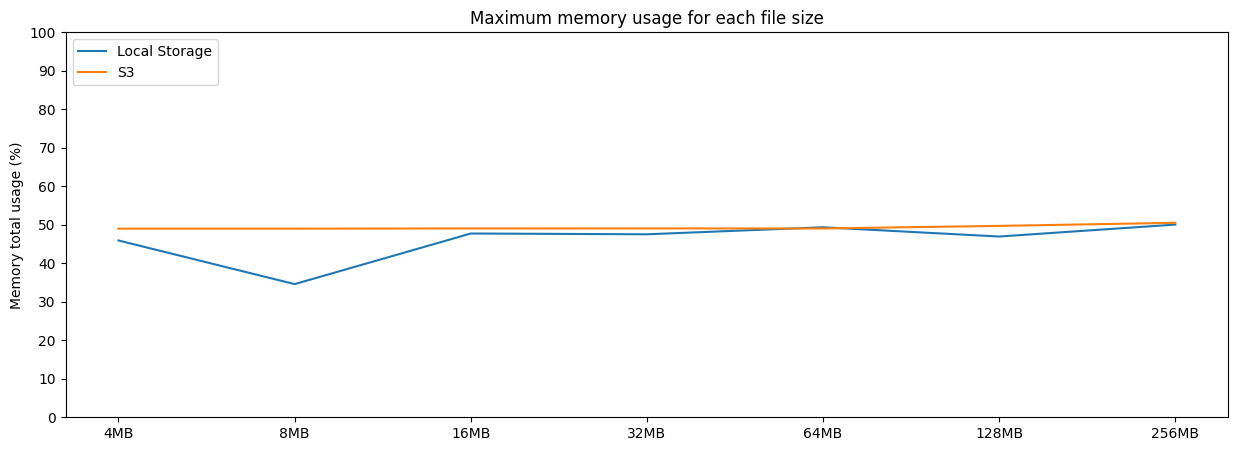

In [54]:
plt.figure(figsize=(15,5))
plt.ylabel("Memory total usage (%)")
plt.title("Maximum memory usage for each file size")
plt.plot(ls_memory_up_df["Max - Memory usage (%)"], label="Local Storage")
plt.plot(s3_memory_up_df["Max - Memory usage (%)"], label="S3")
plt.yticks(list(range(0, 101, 10)))
plt.legend(loc="upper left")

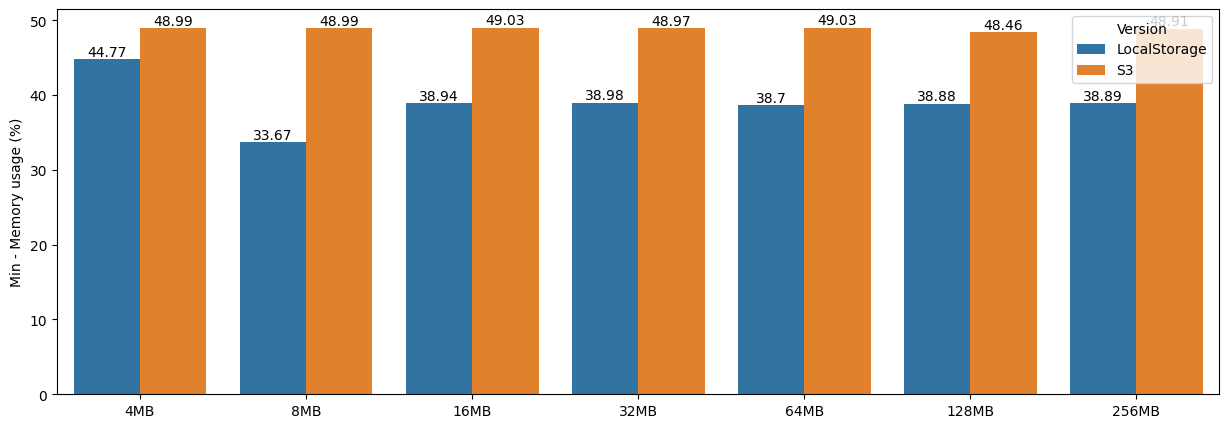

In [55]:
plot_metric(ls_memory_up_df, s3_memory_up_df, "Min - Memory usage (%)")

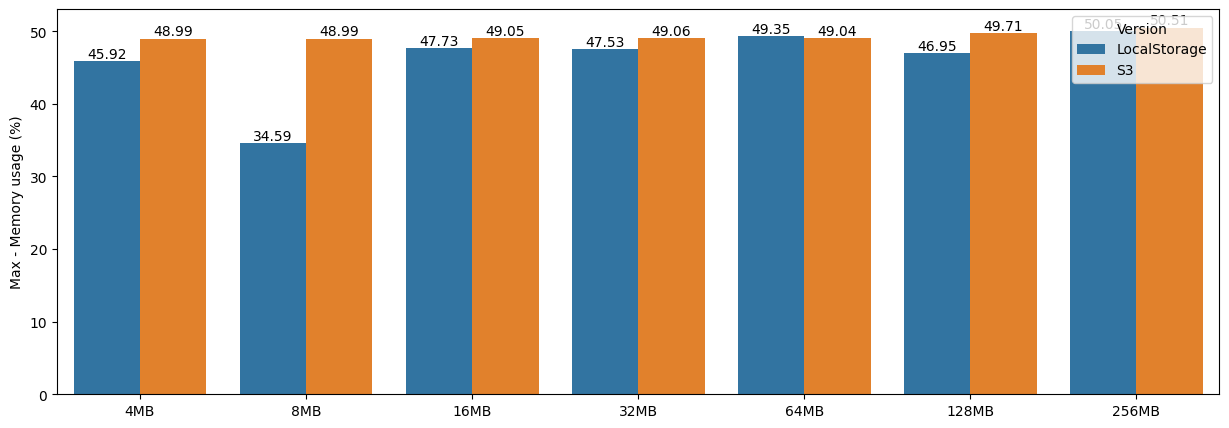

In [56]:
plot_metric(ls_memory_up_df, s3_memory_up_df, "Max - Memory usage (%)")


Versão "LocalStorage" (LS):

Notamos que a versão "LocalStorage" apresentou valores de uso de memória raw do servidor mais elevados em todas as categorias de tamanho de arquivo. Conforme o tamanho do arquivo aumenta, os valores máximos e mínimos de uso de memória raw do servidor na versão "LocalStorage" também tendem a aumentar, embora de forma não tão pronunciada. Essa tendência pode indicar que o impacto no uso de memória é relativamente estável à medida que os arquivos se tornam maiores na versão "LocalStorage".

Uma possível causa para esse comportamento pode estar relacionada com a forma como a versão "LocalStorage" lida com os arquivos durante o processo de upload. Como os dados são armazenados localmente nos discos do servidor, é provável que o aumento no uso de memória esteja relacionado ao processo de leitura e escrita dos arquivos durante a operação de upload. A complexidade e o tempo necessário para essas operações podem influenciar diretamente o consumo de memória, resultando em valores mais elevados.

Versão "S3":

Por outro lado, a versão "S3" também apresenta valores de uso de memória raw do servidor relativamente altos, porém com uma variação mais limitada em comparação com a versão "LocalStorage". À medida que o tamanho do arquivo aumenta, observamos um aumento leve nos valores máximos e mínimos de uso de memória na versão "S3".

Uma possível explicação para esse comportamento pode estar relacionada com o serviço de armazenamento distribuído da AWS utilizado pela versão "S3". Esse serviço é altamente escalável e eficiente em termos de acesso a dados, o que pode minimizar a necessidade de carregar grandes volumes de informações em memória durante o processo de upload. A distribuição dos dados e a utilização de recursos otimizados podem contribuir para a estabilidade nos valores de uso de memória observados.


Utilização de Memória durante o processo de upload ao decorrer do teste para cada tamanho de arquivo


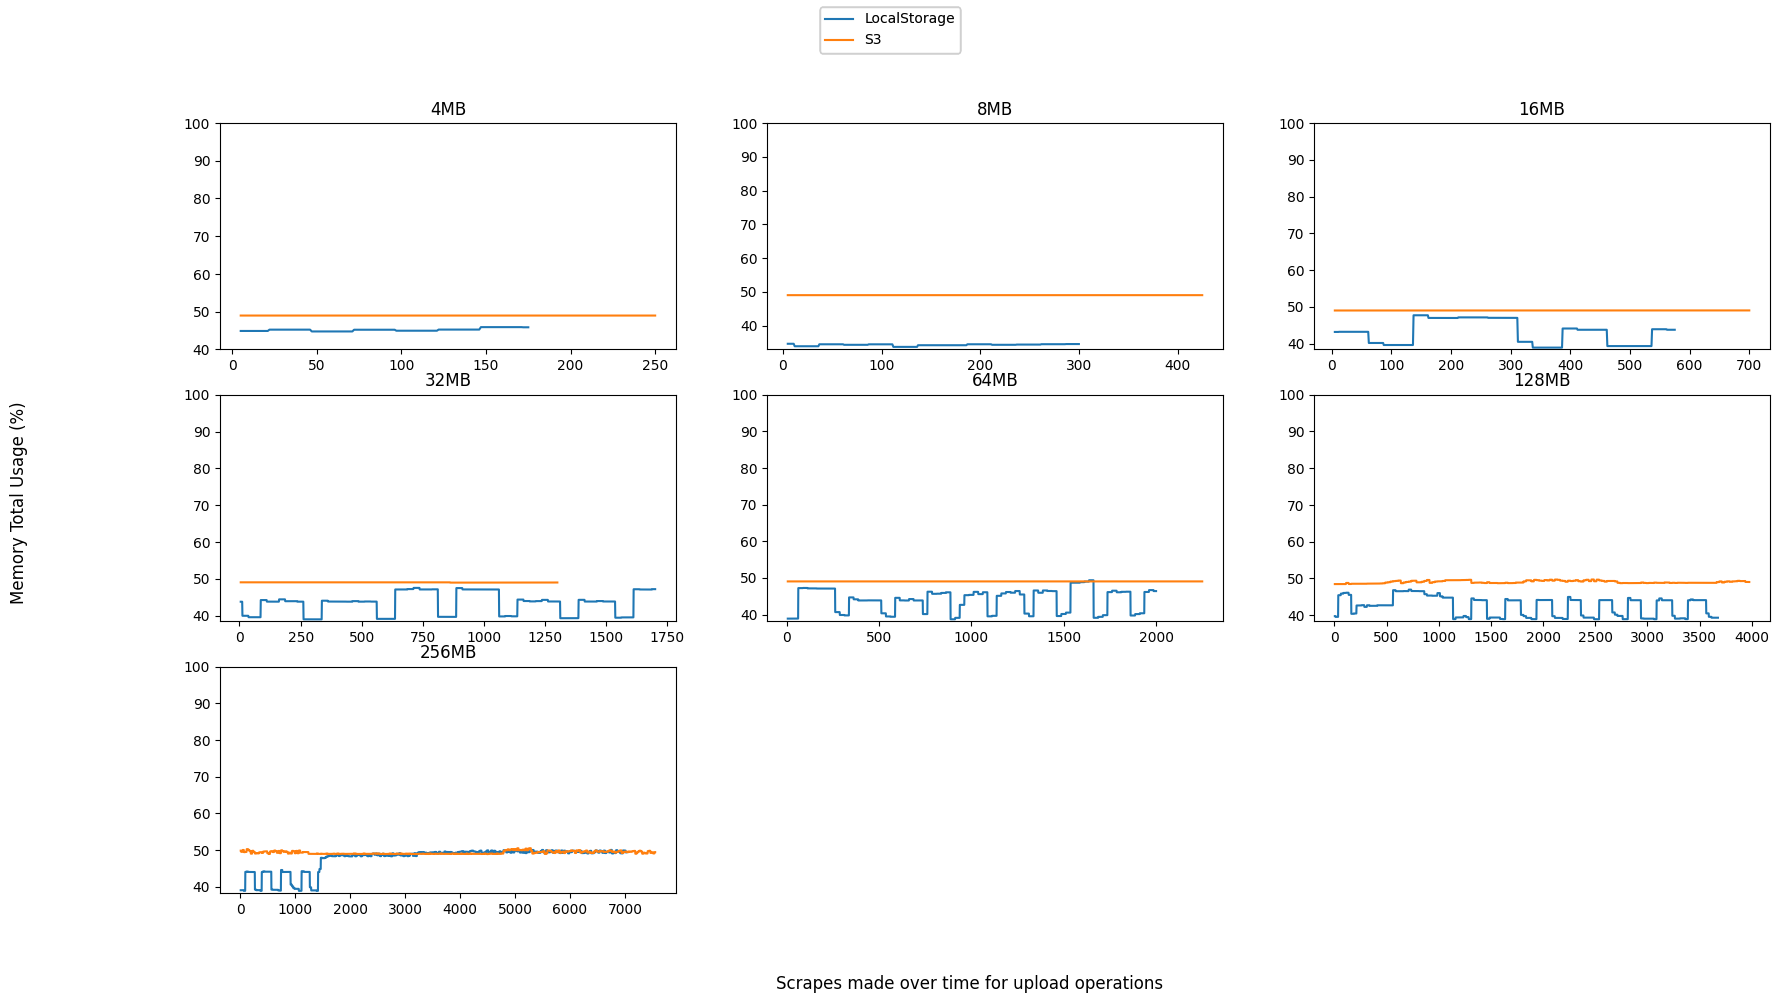

In [57]:
plot_all_size_behaviour_comparison(df_server_dict, "Upload", "raw_usage", supxlabel="Scrapes made over time for upload operations", supylabel="Memory Total Usage (%)",enable_yticks=True, init_yticks=40, limit_yticks=101, step_yticks=10)

Com base na análise dos dados, podemos concluir que ambas as versões apresentam valores de uso de memória raw do servidor elevados, mas com comportamentos distintos à medida que o tamanho do arquivo aumenta. A versão "LocalStorage" tende a ter um impacto mais pronunciado no uso de memória conforme os arquivos se tornam maiores, enquanto a versão "S3" mantém um comportamento mais estável.

Essas diferenças podem ser atribuídas às arquiteturas de armazenamento utilizadas por cada versão. Enquanto a versão "LocalStorage" lida com o armazenamento local, o que pode resultar em operações mais intensivas de leitura e escrita, a versão "S3" aproveita um serviço de armazenamento distribuído, o que pode levar a uma utilização mais eficiente dos recursos de memória.

#### Uso da Memória durante o processamento de operações de Download

##### Tabela com a média e os valores máximos e mínimos para cada tamanho de arquivo em ambas as versões

In [58]:
ls_memory_down_df = get_metrics_server(df_server_dict[VERSIONS[0]]["Download"], "raw_usage", "Memory", "%")
s3_memory_down_df = get_metrics_server(df_server_dict[VERSIONS[1]]["Download"], "raw_usage", "Memory", "%")

In [59]:
ls_memory_down_df

,Average Memory usage (%),Max - Memory usage (%),Min - Memory usage (%),Version
4MB,35.84,45.99,33.02,LocalStorage
8MB,36.60,43.59,34.10,LocalStorage
16MB,42.71,44.42,38.98,LocalStorage
32MB,43.79,48.09,39.40,LocalStorage
64MB,41.96,47.01,38.72,LocalStorage
128MB,41.77,44.89,38.87,LocalStorage
256MB,49.07,50.04,48.97,LocalStorage


In [60]:
s3_memory_down_df

,Average Memory usage (%),Max - Memory usage (%),Min - Memory usage (%),Version
4MB,48.99,48.99,48.99,S3
8MB,49.01,49.03,48.99,S3
16MB,49.05,49.05,49.05,S3
32MB,49.01,49.04,49.00,S3
64MB,49.17,49.78,48.45,S3
128MB,49.10,50.10,48.81,S3
256MB,49.00,50.02,48.92,S3


Ao observar os dados referentes ao uso médio de memória (%) para as operações de download nas versões "LocalStorage" e "S3", podemos notar diferenças significativas no comportamento do consumo de memória entre as duas versões.

Na versão "LocalStorage", o uso médio de memória varia de aproximadamente 35,84% a 49,07%, enquanto na versão "S3", as médias ficam entre 48,99% e 49,17%. Essa discrepância é notável, pois a versão "LocalStorage" apresenta uma faixa mais ampla de valores em relação ao uso médio de memória, enquanto a versão "S3" mantém valores mais próximos entre si.

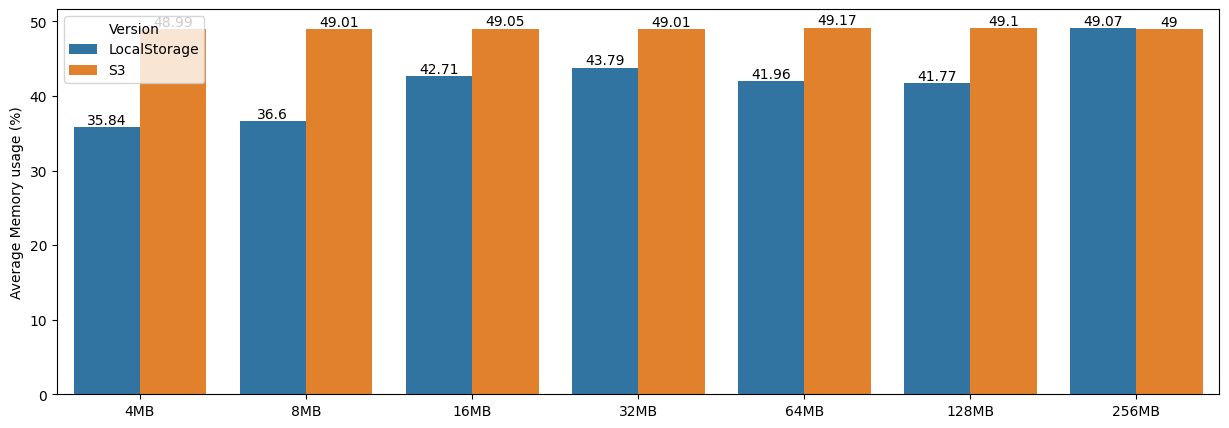

In [61]:
plot_metric(ls_memory_down_df, s3_memory_down_df, "Average Memory usage (%)")

##### Análise do comportamento

Podemos inferir que a versão "LocalStorage" pode ser mais sensível às diferentes operações de download em termos de uso de memória. Essa sensibilidade pode ser atribuída à forma como a versão lida com o armazenamento local dos arquivos durante o processo de download, o que pode levar a uma maior variação no consumo de memória dependendo das características específicas de cada arquivo.

Por outro lado, a versão "S3" utiliza o serviço de armazenamento distribuído da AWS, isso pode explicar a menor variação no uso médio de memória, uma vez que o serviço pode otimizar o consumo de recursos para diferentes operações de download.

A versão "S3" parece ser mais consistente em relação ao uso médio de memória, enquanto a versão "LocalStorage" pode apresentar comportamentos mais variados e, em alguns casos, um uso médio de memória mais baixo.

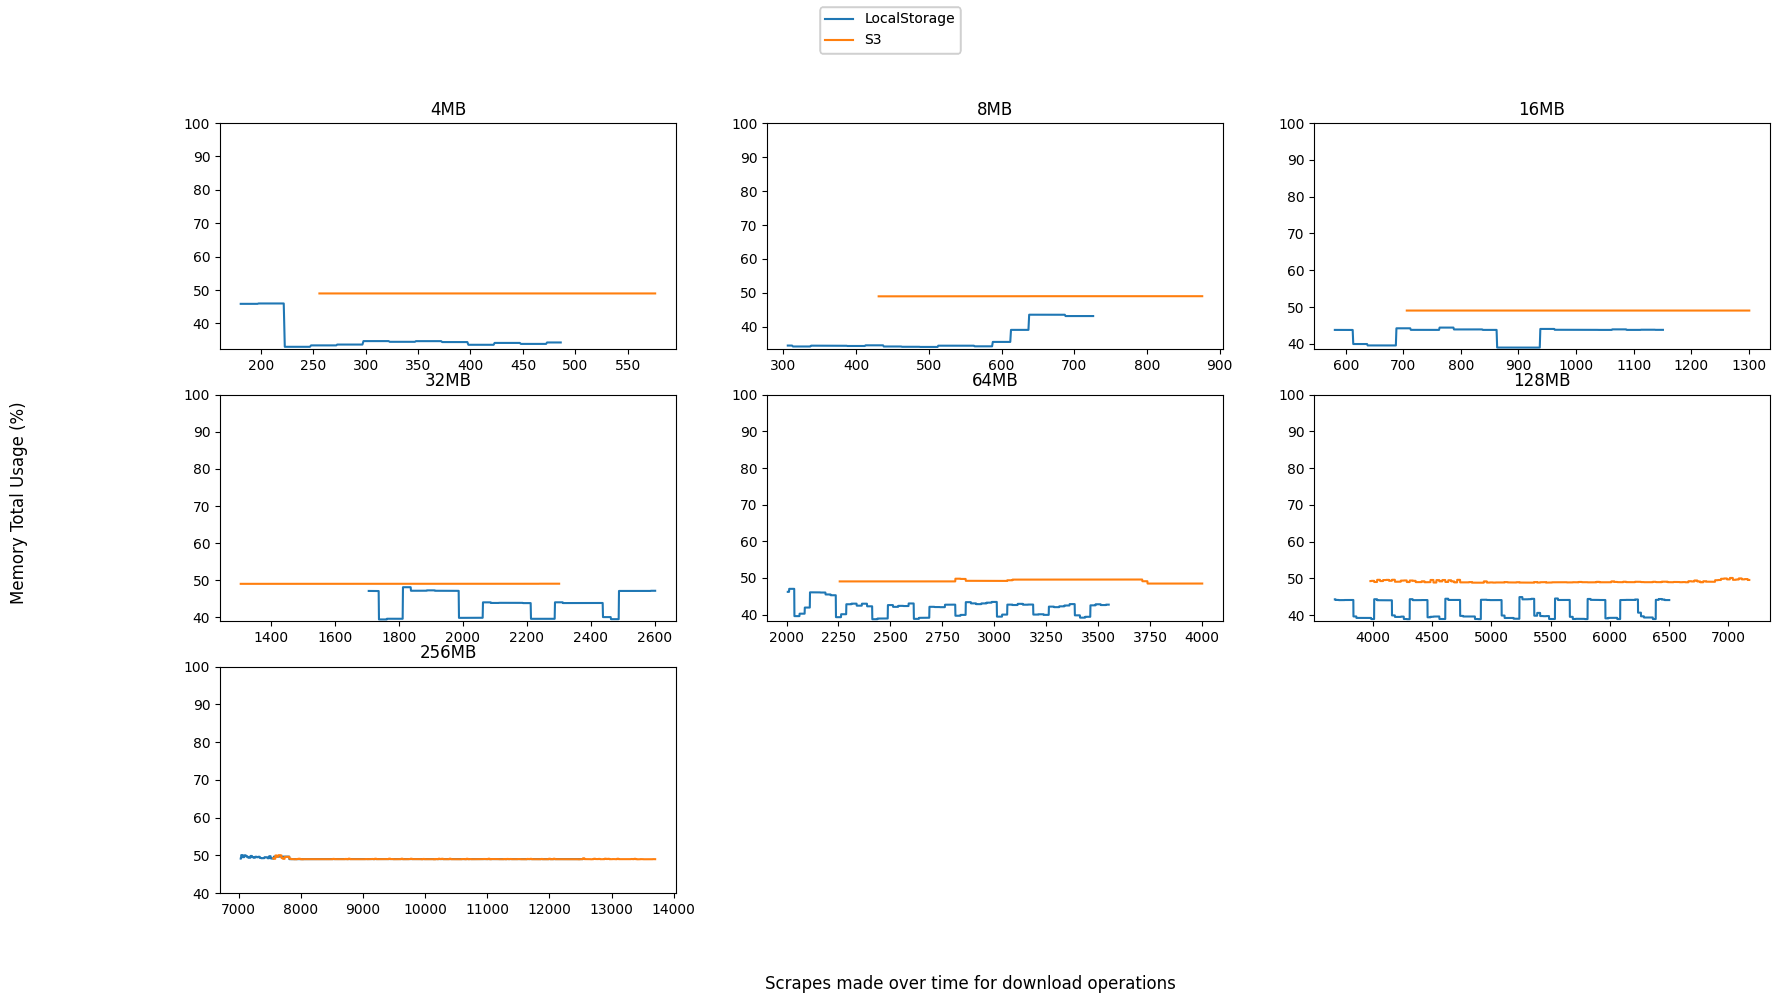

In [62]:
plot_all_size_behaviour_comparison(df_server_dict, "Download", "raw_usage", supxlabel="Scrapes made over time for download operations", supylabel="Memory Total Usage (%)", enable_yticks=True, init_yticks=40, limit_yticks=101, step_yticks=10)

Versão "LocalStorage" (LS):

A versão "LocalStorage" exibe um comportamento variável no uso de memória raw do servidor. Os valores oscilam entre aproximadamente 33% e 50%, demonstrando uma faixa mais ampla de variação em comparação com a versão "S3". Isso pode indicar que a versão "LocalStorage" pode ser mais sensível às características específicas de cada arquivo durante o processo de download, resultando em uma maior flutuação no consumo de memória.

Um possível exemplo de causa para essa variação pode estar relacionado à forma como a versão "LocalStorage" gerencia o carregamento e manipulação dos dados no armazenamento local. Dependendo do tamanho e complexidade de cada arquivo, o servidor pode experimentar diferentes padrões de consumo de memória durante o download.

Versão "S3":

Por outro lado, a versão "S3" exibe uma variação mais limitada no uso de memória raw do servidor. Os valores se mantêm entre aproximadamente 48% e 50%. Isso pode sugerir que a versão "S3" possui uma abordagem mais estável e consistente em relação ao consumo de memória para diferentes tamanhos de arquivo durante as operações de download.

Um possível exemplo de causa para essa estabilidade pode estar relacionado ao serviço de armazenamento distribuído da AWS utilizado pela versão "S3". Esse serviço pode otimizar o uso de recursos de memória, garantindo um comportamento mais uniforme e previsível, independentemente do tamanho ou complexidade dos arquivos.

A análise dos dados indica que a versão "LocalStorage" pode apresentar uma variação mais ampla no uso de memória raw do servidor em comparação com a versão "S3" durante as operações de download. 